# GARCH Model for Volatility Forecasting
This notebook demonstrates how to use a GARCH (Generalized Autoregressive Conditional Heteroskedasticity) model to forecast stock price volatility.

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from arch import arch_model
import matplotlib.pyplot as plt
import datetime


## 1. Fetch Historical Stock Data
Define the ticker symbol and the time period for which to fetch data.

In [76]:
ticker_symbol = "AAPL" # Example: Apple Inc.
end_date = datetime.datetime.now()
start_date = end_date - datetime.timedelta(days=5*365) # 5 years of data

# Fetch data
data = yf.download(ticker_symbol, start=start_date, end=end_date, auto_adjust=True)

# Display the last few rows
print(f"Fetched {len(data)} data points for {ticker_symbol}")
print(data.tail())

[*********************100%***********************]  1 of 1 completed

Fetched 1255 data points for AAPL
Price            Close        High         Low        Open     Volume
Ticker            AAPL        AAPL        AAPL        AAPL       AAPL
Date                                                                 
2025-05-01  213.320007  214.559998  208.899994  209.080002   57365700
2025-05-02  205.350006  206.990005  202.160004  206.089996  101010600
2025-05-05  198.889999  204.100006  198.210007  203.100006   69018500
2025-05-06  198.509995  200.649994  197.020004  198.210007   51216500
2025-05-07  196.250000  199.440002  193.250000  199.169998   68536700


## 2. Calculate Log Returns
GARCH models are typically applied to the returns of an asset, often log returns.


Log Returns (tail):
Ticker          AAPL
Date                
2025-05-01  0.003851
2025-05-02 -0.038078
2025-05-05 -0.031964
2025-05-06 -0.001912
2025-05-07 -0.011450


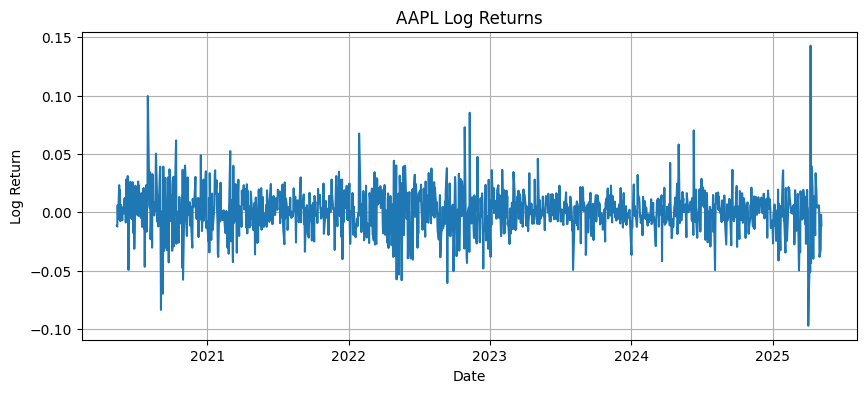

In [77]:
# Calculate log returns
log_returns = np.log(data['Close'] / data['Close'].shift(1)).dropna()

# Display the last few log returns
print("\nLog Returns (tail):")
print(log_returns.tail())

# Plot log returns
plt.figure(figsize=(10, 4))
plt.plot(log_returns)
plt.title(f'{ticker_symbol} Log Returns')
plt.ylabel('Log Return')
plt.xlabel('Date')
plt.grid(True)
plt.show()

## 3. Fit GARCH Model
We will fit a GARCH(1,1) model, which is a common choice.
The model assumes that the variance of returns at time `t` depends on the squared return at `t-1` (ARCH term) and the variance at `t-1` (GARCH term).

We use `arch_model` from the `arch` library.
- `p`: Order of the ARCH terms (lagged squared residuals).
- `q`: Order of the GARCH terms (lagged conditional variances).
- `vol='Garch'`: Specifies the GARCH volatility process.
- `mean='Constant'`: Assumes a constant mean for the returns. Can also use 'Zero' or 'ARX'.
- `dist='Normal'`: Assumes normally distributed errors. Other distributions like 't' can be used.
- `rescale=False`: Important if input returns are not scaled (e.g., by 100).

In [78]:
# Define the GARCH(1,1) model
# Using fractional log_returns directly. 
garch_model = arch_model(log_returns, vol='Garch', p=1, q=1, mean='Constant', rescale=False)

# Fit the model
# disp='off' suppresses convergence output
try:
    garch_results = garch_model.fit(disp='off')
    # Print the model summary
    print("\nGARCH Model Summary:")
    print(garch_results.summary())
except Exception as e:
    print(f"Error fitting GARCH model: {e}")
    garch_results = None


GARCH Model Summary:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                3290.75
Distribution:                  Normal   AIC:                          -6573.50
Method:            Maximum Likelihood   BIC:                          -6552.96
                                        No. Observations:                 1254
Date:                Thu, May 08 2025   Df Residuals:                     1253
Time:                        01:39:25   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.0444e-03  5.789e-05    

## 4. Forecast Volatility
Once the model is fitted, we can use it to forecast future conditional volatility.
We will forecast the 1-day ahead volatility.

In [79]:
if garch_results:
    # Forecast volatility for the next trading day
    forecast_horizon = 1
    forecasts = garch_results.forecast(horizon=forecast_horizon, reindex=False)

    # The forecasted variance is in forecast.variance
    # Access the last row (latest forecast) and the h.1 column (1-step ahead)
    forecasted_variance_daily = forecasts.variance.iloc[-1, 0]
    
    # Convert daily variance to daily volatility (standard deviation)
    forecasted_volatility_daily = np.sqrt(forecasted_variance_daily)

    # Annualize the daily volatility
    # Assuming 252 trading days in a year
    annualized_factor = np.sqrt(252)
    forecasted_volatility_annualized = forecasted_volatility_daily * annualized_factor

    print("\nVolatility Forecast:")
    print(f"Forecasted 1-day ahead Daily Volatility: {forecasted_volatility_daily:.6f}")
    print(f"Forecasted 1-day ahead Annualized Volatility: {forecasted_volatility_annualized:.4f} (or {forecasted_volatility_annualized*100:.2f}%)")
else:
    print("\nSkipping forecast due to GARCH model fitting error.")
    forecasted_volatility_daily = np.nan
    forecasted_volatility_annualized = np.nan


Volatility Forecast:
Forecasted 1-day ahead Daily Volatility: 0.029121
Forecasted 1-day ahead Annualized Volatility: 0.4623 (or 46.23%)


## 5. Visualize Conditional Volatility
Plot the fitted conditional volatility from the GARCH model against the actual returns.

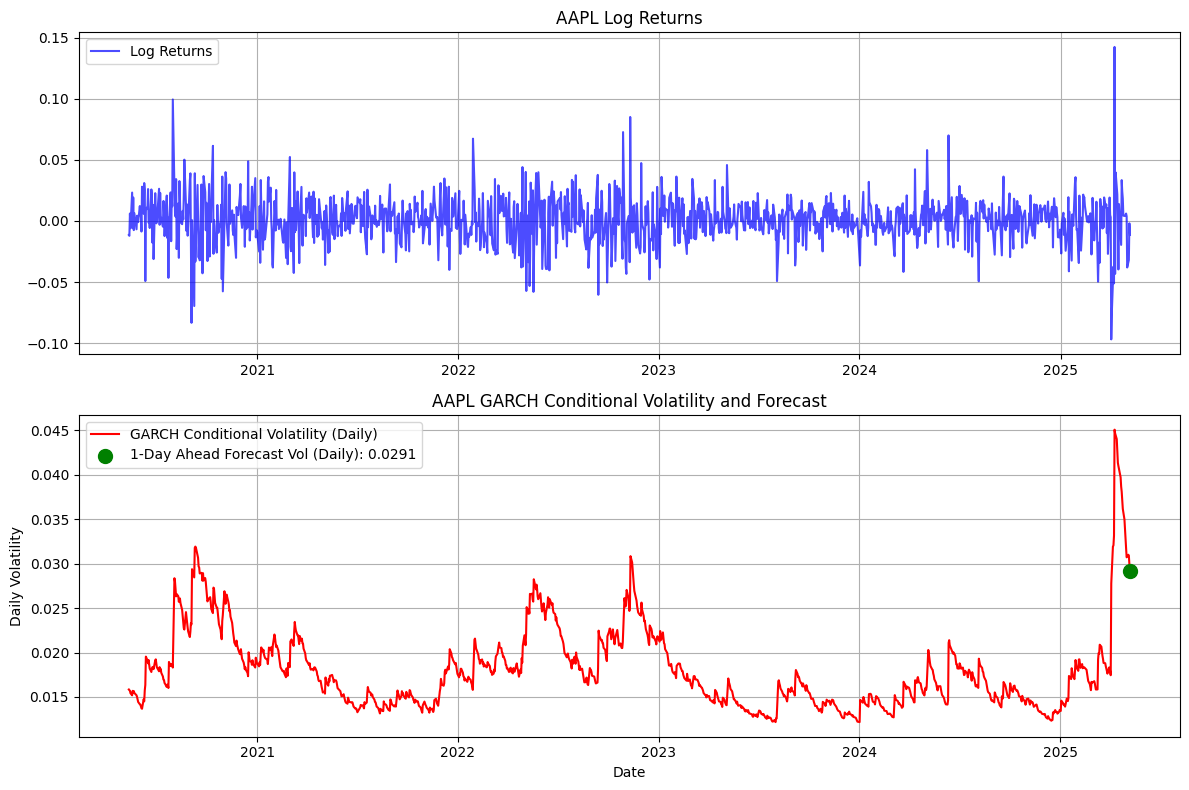


Final Volatility Figures:
Last observed daily conditional volatility: 0.029932
Forecasted next day daily volatility: 0.029121
Forecasted next day annualized volatility: 0.4623


In [80]:
if garch_results:
    # Get the conditional volatility from the fitted GARCH model results
    conditional_volatility_daily = garch_results.conditional_volatility

    plt.figure(figsize=(12, 8))
    # Plot log returns
    plt.subplot(2, 1, 1)
    plt.plot(log_returns.index, log_returns, label='Log Returns', color='blue', alpha=0.7)
    plt.title(f'{ticker_symbol} Log Returns')
    plt.legend()
    plt.grid(True)

    # Plot conditional volatility (daily)
    plt.subplot(2, 1, 2)
    plt.plot(conditional_volatility_daily.index, conditional_volatility_daily, label='GARCH Conditional Volatility (Daily)', color='red')
    
    # Add the one-step ahead forecast point
    if not np.isnan(forecasted_volatility_daily) and conditional_volatility_daily.index.size > 0:
        forecast_date = conditional_volatility_daily.index[-1] + pd.Timedelta(days=1) # Approximate next day
        plt.scatter(forecast_date, forecasted_volatility_daily, color='green', marker='o', s=100, zorder=5, 
                    label=f'1-Day Ahead Forecast Vol (Daily): {forecasted_volatility_daily:.4f}')
    
    plt.title(f'{ticker_symbol} GARCH Conditional Volatility and Forecast')
    plt.ylabel('Daily Volatility')
    plt.xlabel('Date')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    print("\nFinal Volatility Figures:")
    if conditional_volatility_daily.size > 0:
        print(f"Last observed daily conditional volatility: {conditional_volatility_daily.iloc[-1]:.6f}")
    print(f"Forecasted next day daily volatility: {forecasted_volatility_daily:.6f}")
    print(f"Forecasted next day annualized volatility: {forecasted_volatility_annualized:.4f}")
else:
    print("\nSkipping visualization due to GARCH model fitting error.")